In [1]:
%config Completer.use_jedi = False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandasql as ps

In [2]:
data_path = './test-recsys/'  # ../input

In [3]:
import os

In [4]:
os.listdir(data_path)

['kaggle_tab_1345',
 'sample_submission.csv',
 'sbermarket_tab_2_1',
 'sbermarket_tab_2_2',
 'sbermarket_tab_2_3',
 'sbermarket_tab_2_4',
 'sbermarket_tab_2_5',
 'sbermarket_tab_2_6',
 'tab_6_city.csv']

## Categoties table analysis

In [5]:
cat = pd.read_csv(data_path + 'kaggle_tab_1345/tab_3_categories.csv')

In [19]:
hier = cat
i=0

q = """
select t1.id as lvl_""" + str(i) + """_id,
    t1.name as lvl_""" + str(i) + """_name,
    t1.parent_id as lvl_""" + str(i+1) + """_id,
    t2.name as lvl_""" + str(i+1) + """_name,
    t2.parent_id as lvl_""" + str(i+2) + """_id
from hier t1
left join cat t2
on t1.parent_id == t2.id

"""
hier = ps.sqldf(q)
i = i + 1
hier['lvl_' + str(i) + '_name'].fillna("",inplace=True)
hier['lvl_' + str(i+1) + '_id'].fillna(0.0,inplace=True)

while not (hier['lvl_' + str(i+1) + '_id'] == 0.0).all():
    
    q = """
    select t1.*,
        t2.name as lvl_""" + str(i+1) + """_name,
        t2.parent_id as lvl_""" + str(i+2) + """_id
    from hier t1
    left join cat t2
    on t1.lvl_""" + str(i+1) + """_id == t2.id

    """
    hier = ps.sqldf(q)
    i = i + 1  
    hier['lvl_' + str(i) + '_name'].fillna("",inplace=True)
    hier['lvl_' + str(i+1) + '_id'].fillna(0.0,inplace=True)

# hier.drop(['lvl_' + str(i+1) + '_id'], axis=1, inplace=True)

In [10]:
hier.head()

,lvl_0_id,lvl_0_name,lvl_1_id,lvl_1_name,lvl_2_id,lvl_2_name,lvl_3_id
0,1,Продукты питания,0,,0.0,,0.0
1,2,Замороженные продукты,1,Продукты питания,0.0,,0.0
2,3,Замороженные овощи и фрукты,2,Замороженные продукты,1.0,Продукты питания,0.0
3,4,Замороженные полуфабрикаты,2,Замороженные продукты,1.0,Продукты питания,0.0
4,5,Рыба замороженная,2,Замороженные продукты,1.0,Продукты питания,0.0


In [49]:
(hier.lvl_1_id == 0).sum()

24

In [50]:
(hier.lvl_2_id == 0).sum()

207

In [51]:
(hier.lvl_3_id == 0).sum()

1016

In [52]:
(hier.lvl_2_id != 0).sum()

809

In [54]:
(hier.lvl_1_id != 0).sum()

992

__!!! NEED TO CHECK HOW COLUMN MASTER_CATEGORY FOR PRODUCTS IS CONNECTED TO THE HIERARCHY. is it covered by the ids with lvl2_id != 0?__

## Order table analysis

In [61]:
# orders = pd.read_csv('./tab_1_orders.csv')


orders = pd.read_csv(f'{data_path}/kaggle_tab_1345/tab_1_orders.csv')

In [12]:
orders.head()

,user_id,order_id,order_created_time,retailer,store_id,platform
0,72,17431000,2020-09-26 10:48:57,METRO,21,app
1,83,9718154,2020-05-08 09:46:18,METRO,87,web
2,142,10056850,2020-05-14 15:06:03,METRO,320,app
3,187,15952443,2020-09-01 17:34:00,ВкусВилл,533,app
4,224,10409918,2020-05-20 06:32:50,Ашан,183,web


In [ ]:
q = """
select t1.*,
    t2.order_created_time
from prod t1
left join orders t2
on t1.user_id == t2.user_id and t1.order_id == t2.order_id

"""
ps.sqldf(q)

In [ ]:
orders = orders.sort_values(['user_id', 'order_created_time','order_id'])

In [ ]:
tmp = orders.groupby(['user_id', 'order_id']).order_created_time.agg('count')

In [ ]:
(tmp > 1).sum()

In [ ]:
tmp.value_counts()

In [ ]:
tmp[tmp==4]

In [ ]:
duplicates = orders[orders.set_index(['user_id', 'order_id']).index.isin((tmp[tmp==4].keys()))]

In [ ]:
duplicates.head()

In [ ]:
duplicates.groupby(['user_id', 'order_id']).retailer.nunique()

__!!! if there are several rows with the same order and time, this means that user offers goods from different retailers. Probably, it will be more convenient to recommend products from one retailer__

In [ ]:
order_cnt = orders.drop_duplicates(['user_id', 'order_id']).groupby('user_id').order_id.agg('count')

In [ ]:
(order_cnt >1).sum()

In [ ]:
order_cnt.clip(upper=order_cnt.quantile(0.99)).plot(kind='hist', bins=25)

__!!! for most of the users we don't have big history of purchaises. So it will be difficult to calculate statistics.__

## Products table analysis

In [5]:
from tqdm.notebook import tqdm

In [6]:
for i in tqdm(range(6,4,-1)):
    for j, name in enumerate(os.listdir(data_path+'sbermarket_tab_2_' + str(i))[::-1]):
        print(data_path+'sbermarket_tab_2_' + str(i)  + '/' + name)
        if i==6 and j==0:
            prod = pd.read_csv(data_path+'sbermarket_tab_2_' + str(i) + '/' + name)
        else:
            t = pd.read_csv(data_path+'sbermarket_tab_2_' + str(i) + '/' + name)
            prod = prod.append(t)
#         print(prod.shape)

./test-recsys/sbermarket_tab_2_6/tab_2_products_2020-09-07.csv
./test-recsys/sbermarket_tab_2_6/tab_2_products_2020-08-28.csv
./test-recsys/sbermarket_tab_2_6/tab_2_products_2020-08-18.csv
./test-recsys/sbermarket_tab_2_6/tab_2_products_2020-08-08.csv
./test-recsys/sbermarket_tab_2_5/tab_2_products_2020-07-29.csv
./test-recsys/sbermarket_tab_2_5/tab_2_products_2020-07-19.csv
./test-recsys/sbermarket_tab_2_5/tab_2_products_2020-07-09.csv



In [13]:
# import gc
# gc.collect()
# gc.collect()
# gc.collect()
# gc.collect()

In [8]:
prod.shape

(20279418, 11)

In [14]:
tmp = prod.groupby('user_id').order_id.nunique()

<AxesSubplot:ylabel='Frequency'>

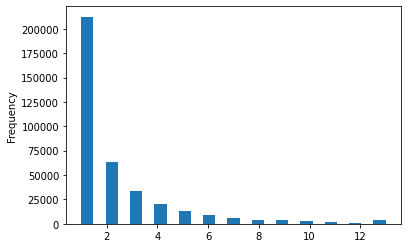

In [17]:
tmp.clip(upper=tmp.quantile(0.99)).plot(kind='hist', bins=25)

In [33]:
master_cat_list = pd.Series(prod.master_category_id.unique())

In [34]:
(master_cat_list.isin(hier[hier.lvl_2_id != 0].lvl_0_id.values) == False).sum()

49

In [35]:
len(master_cat_list)

612

In [36]:
(master_cat_list.isin(hier.lvl_0_id) == False).sum()

1

__!!! master_category_id = lvl_0_id__

In [33]:
hier.head()

,lvl_0_id,lvl_0_name,lvl_1_id,lvl_1_name,lvl_2_id,lvl_2_name,lvl_3_id
0,1,Продукты питания,0,,0.0,,0.0
1,2,Замороженные продукты,1,Продукты питания,0.0,,0.0
2,3,Замороженные овощи и фрукты,2,Замороженные продукты,1.0,Продукты питания,0.0
3,4,Замороженные полуфабрикаты,2,Замороженные продукты,1.0,Продукты питания,0.0
4,5,Рыба замороженная,2,Замороженные продукты,1.0,Продукты питания,0.0


In [37]:
(hier[hier.lvl_0_id.isin(master_cat_list)].lvl_2_id == 0).sum()

48

In [42]:
tmp = prod.groupby('user_id').order_id.nunique()

<AxesSubplot:ylabel='Frequency'>

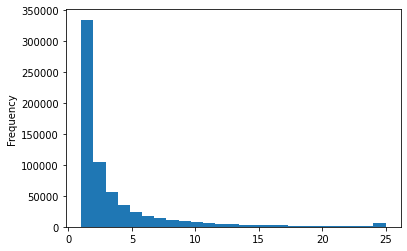

In [44]:
tmp.clip(upper=tmp.quantile(0.99)).plot(kind='hist', bins=25)

In [19]:
prod.parent_category_id.value_counts().loc[0]

623603

In [21]:
prod[prod.parent_category_id == 0].master_category_id.value_counts()

477.0    76
475.0    41
474.0    12
Name: master_category_id, dtype: int64

In [42]:
prod[prod.dtypes.keys()[prod.dtypes == 'int64']].astype('int32')

MemoryError: Unable to allocate 2.20 GiB for an array with shape (5, 58973506) and data type float64

## Model (baseline)

In [7]:
sbm = pd.read_csv(f'{data_path}/sample_submission.csv')

In [8]:
users = sbm.Id.values

In [9]:
users.size

107068

In [10]:
prod.isna().sum()

user_id                    0
order_id                   0
line_item_id               0
price                      0
quantity                   0
discount                   0
product_name          179009
product_id                 0
brand_name            672946
master_category_id    182609
parent_category_id         0
dtype: int64

In [11]:
prod.master_category_id.fillna(-1, inplace=True)

In [12]:
prod.brand_name.fillna('unk', inplace=True)

In [13]:
prod.master_category_id = prod.master_category_id.astype('int64')

In [14]:
prod.head()

,user_id,order_id,line_item_id,price,quantity,discount,product_name,product_id,brand_name,master_category_id,parent_category_id
0,65,16095339,170790864,119.000000,1,96.0,Шоколад Lindt Excellence горький 78%,201286,Lindt,60,56
1,65,16095339,170790865,172.839996,1,0.0,Грейпфрут,105764,Без бренда,91,90
2,65,16095339,170790866,118.000000,2,0.0,"Творог Valio мягкий обезжиренный 0,1% бзмж",26062,Valio,30,20
3,65,16095339,170790867,276.329987,1,0.0,Яблоки Роял Гала,3302524,Без бренда,91,90
4,65,16095339,170790868,379.010010,1,0.0,Авокадо,54728,Без бренда,85,84


find most popular products

In [15]:
most_pop_prods = prod.groupby('product_id').order_id.nunique().nlargest(50).index

In [16]:
prod.user_id.nunique()

374412

In [17]:
np.intersect1d(prod.user_id.unique(), users).size

96382

In [18]:
cnt_user_items = prod.groupby('user_id').product_id.nunique()

<AxesSubplot:ylabel='Frequency'>

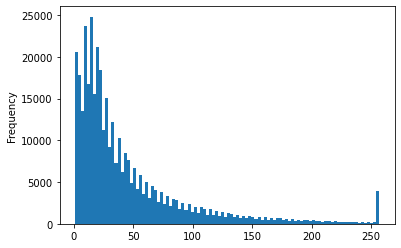

In [19]:
# plt.figure(figsize)
cnt_user_items.clip(upper=cnt_user_items.quantile(0.99)).plot(kind='hist', bins=100)

In [20]:
(cnt_user_items > 250).sum()

4149

In [21]:
(cnt_user_items > 50).sum()

107360

In [22]:
(cnt_user_items <= 50).sum()

267052

In [23]:
cnt_user_items

user_id
51         59
65         76
187         2
353        21
359         8
           ..
3142901     4
3142924     8
3142936     9
3142965    18
3142966    25
Name: product_id, Length: 374412, dtype: int64

In [24]:
cnt_user_items.shape

(374412,)

In [25]:
train_users = set(cnt_user_items.index.values.tolist())

In [26]:
test_users = set(users.tolist())

In [27]:
len(test_users - train_users)

10686

In [29]:
goods = prod[['product_id', 'brand_name', 'master_category_id', 'parent_category_id']]  # , 'order_id', 'price'

In [30]:
unique_goods = goods.drop_duplicates()


In [31]:
unique_goods

,product_id,brand_name,master_category_id,parent_category_id
0,201286,Lindt,60,56
1,105764,Без бренда,91,90
2,26062,Valio,30,20
3,3302524,Без бренда,91,90
4,54728,Без бренда,85,84
...,...,...,...,...
2918172,5574804,Danone,-1,0
2918177,5582199,Просто Азбука,-1,0
2919835,24344,Dosia,249,243
2921185,3845861,Планета Витаминов,592,90


In [32]:
unique_goods.master_category_id.nunique()

602

In [33]:
brand_counts = goods.brand_name.value_counts()
brand_counts = pd.DataFrame(brand_counts).rename(columns={'brand_name': 'brand_count'})

goods2 = unique_goods.merge(brand_counts, left_on='brand_name', right_index=True)
goods3 = goods2.drop(columns=['brand_name'])
goods3

,product_id,master_category_id,parent_category_id,brand_count
0,201286,60,56,22886
825,25400,61,56,22886
3734,17318,60,56,22886
3887,17316,60,56,22886
4401,17312,60,56,22886
...,...,...,...,...
2606188,10913689,660,156,1
2615589,7385952,85,84,1
2732525,7385385,637,84,1
2792286,16721,61,56,1


In [34]:
master_cat_counts = goods.master_category_id.value_counts()
master_cat_counts = pd.DataFrame(master_cat_counts).rename(columns={'master_category_id': 'master_cat_count'})

goods4 = goods3.merge(master_cat_counts, left_on='master_category_id', right_index=True)
goods5 = goods4.drop(columns=['master_category_id'])
goods5

,product_id,parent_category_id,brand_count,master_cat_count
0,201286,56,22886,436324
3734,17318,56,22886,436324
3887,17316,56,22886,436324
4401,17312,56,22886,436324
4405,17329,56,22886,436324
...,...,...,...,...
1680157,5071869,502,1,1
77745,55328,392,1,1
394431,3289,453,6,6
948860,5474521,546,2,2


In [35]:
parent_cat_counts = goods.parent_category_id.value_counts()
parent_cat_counts = pd.DataFrame(parent_cat_counts).rename(columns={'parent_category_id': 'parent_cat_count'})

goods6 = goods5.merge(parent_cat_counts, left_on='parent_category_id', right_index=True)
goods7 = goods6.drop(columns=['parent_category_id'])
goods7

,product_id,brand_count,master_cat_count,parent_cat_count
0,201286,22886,436324,1353195
3734,17318,22886,436324,1353195
3887,17316,22886,436324,1353195
4401,17312,22886,436324,1353195
4405,17329,22886,436324,1353195
...,...,...,...,...
1070387,5216575,155,26,109
1438183,5216566,155,26,109
2476909,5216570,155,26,109
205395,5216587,155,26,109


In [36]:
for col in ['brand_count', 'master_cat_count', 'parent_cat_count']:
    new_col = col + '_norm'
    goods7[new_col] = goods7[col] / brand_counts.sum().values  # goods7[col].sum()

goods8 = goods7.drop(columns=['brand_count','master_cat_count','parent_cat_count'])

goods8

,product_id,brand_count_norm,master_cat_count_norm,parent_cat_count_norm
0,201286,0.001129,2.151561e-02,6.672751e-02
3734,17318,0.001129,2.151561e-02,6.672751e-02
3887,17316,0.001129,2.151561e-02,6.672751e-02
4401,17312,0.001129,2.151561e-02,6.672751e-02
4405,17329,0.001129,2.151561e-02,6.672751e-02
...,...,...,...,...
1070387,5216575,0.000008,1.282088e-06,5.374908e-06
1438183,5216566,0.000008,1.282088e-06,5.374908e-06
2476909,5216570,0.000008,1.282088e-06,5.374908e-06
205395,5216587,0.000008,1.282088e-06,5.374908e-06


In [37]:
prod

,user_id,order_id,line_item_id,price,quantity,discount,product_name,product_id,brand_name,master_category_id,parent_category_id
0,65,16095339,170790864,119.000000,1,96.0,Шоколад Lindt Excellence горький 78%,201286,Lindt,60,56
1,65,16095339,170790865,172.839996,1,0.0,Грейпфрут,105764,Без бренда,91,90
2,65,16095339,170790866,118.000000,2,0.0,"Творог Valio мягкий обезжиренный 0,1% бзмж",26062,Valio,30,20
3,65,16095339,170790867,276.329987,1,0.0,Яблоки Роял Гала,3302524,Без бренда,91,90
4,65,16095339,170790868,379.010010,1,0.0,Авокадо,54728,Без бренда,85,84
...,...,...,...,...,...,...,...,...,...,...,...
2925647,2435612,13639884,136293736,69.000000,1,0.0,Сметана Простоквашино из топленых сливок 15% 1...,2564091,Простоквашино,29,20
2925648,2435612,13639884,136293814,117.000000,1,0.0,Мороженое молочное Oreo с печеньем 62 г,3566277,Oreo,33,20
2925649,2435612,13639884,136294047,103.000000,1,0.0,Мороженое сливочное Магнат Гранат 72 г,5075958,unk,33,20
2925650,2435612,13639884,136298302,149.000000,1,0.0,Картофель фри 4 Сезона быстрозамороженный 450 г,7033753,4 Сезона,87,84


In [38]:
# prod[['price', 'reg_price', '']]

In [39]:
prod['reg_price'] = prod.price + prod.discount
prods = prod.copy()[['product_id', 'order_id', 'reg_price']]

prods

,product_id,order_id,reg_price
0,201286,16095339,215.000000
1,105764,16095339,172.839996
2,26062,16095339,118.000000
3,3302524,16095339,276.329987
4,54728,16095339,379.010010
...,...,...,...
2925647,2564091,13639884,69.000000
2925648,3566277,13639884,117.000000
2925649,5075958,13639884,103.000000
2925650,7033753,13639884,149.000000


In [40]:
# # for product_id in tqdm(prods.product_id.unique()):
# # #     print(product_id)
# #     cur_prods = prods[prods.product_id == product_id]
# #     cur_prods = cur_prods.sort_values(by='order_id')
# #     reg_prices = np.r_[cur_prods.reg_price.iloc[0], cur_prods.reg_price.values[:-1]]
# #     cur_prods['reg_price'] = reg_prices
# # #     prods.loc[cur_prods.index, 'prev_reg_price'] = cur_prods.reg_price
# #     break

# # cur_prods

# # tmp[tmp.index == product_id]

# # tmp[tmp.prod]

# # # g = prods \
# # #     .sort_values('order_id') \
# # #     .groupby('product_id')
# # # #     .apply(lambda x: pd.Series(np.r_[x.iloc[0], x.values[:-1, 0]]))
# # # # .reg_price.shift(1)  # .head(10)#reg_price.shift(1)

# # # tmp = g.apply(lambda x: x.shift())
# # # tmp

# cur_prods.reg_price.shift()

# cur_prods

# cur_prods

# prod[prod.product_id == 201286].sort_values(by='order_id')

In [41]:
prod = prod[prod.product_id != 0]

In [42]:
importances = prod.groupby('product_id').quantity.sum()

In [43]:
importances.loc[5481337] /= 500

In [44]:
importances.sort_values(ascending=False, inplace=True)
importances

product_id
709        125399.0
158        116057.0
1300        94386.0
166         73123.0
9959        68837.0
             ...   
7040852         1.0
7040849         1.0
6565208         1.0
6747239         1.0
61340           1.0
Name: quantity, Length: 90756, dtype: float64

<AxesSubplot:ylabel='Frequency'>

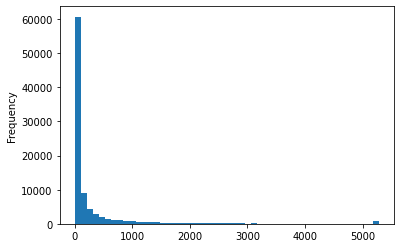

In [45]:
importances.clip(upper=importances.quantile(0.99)).plot(kind='hist', bins=50)

In [54]:
# prod[prod.product_id == 5481337]

In [46]:
prod = prod.sort_values(['user_id', 'order_id'])

In [47]:
prod

,user_id,order_id,line_item_id,price,quantity,discount,product_name,product_id,brand_name,master_category_id,parent_category_id,reg_price
0,51,13911065,145635438,149.899994,1,0.000000,Кукуруза сладкая в вакууме 230 г,6005183,Без бренда,85,84,149.899994
1,51,13911065,145635468,74.900002,1,0.000000,Морковь Белая Дача сочная 250 г,15148,Белая Дача,85,84,74.900002
2,51,13911065,145635515,149.899994,5,0.000000,Томаты Черри Мое лето Санрайз красные 250 г,63057,Мое лето,85,84,149.899994
3,51,13911065,145635542,99.900002,1,0.000000,Огурцы Луховицкие,3497570,Без бренда,85,84,99.900002
4,51,13911065,145635579,59.900002,2,0.000000,Томаты черри сливка,688,unk,85,84,59.900002
...,...,...,...,...,...,...,...,...,...,...,...,...
3167950,3142966,16654689,173388143,34.889999,1,17.700001,"Йогурт Epica гранат и малина 4,8% 130 г бзмж",71049,Epica,21,20,52.590000
3167951,3142966,16654689,173388392,63.889999,1,73.000000,Шоколад Ritter Sport молочный с начинкой Клубн...,96217,Ritter Sport,60,56,136.889999
3167952,3142966,16654689,173388690,63.889999,1,82.500000,Шоколад Ritter Sport молочный с начинкой Карам...,94125,Ritter Sport,60,56,146.389999
3167953,3142966,16654689,173388868,298.489990,1,0.000000,Филе цыпленка-бройлера Троекурово охлажденное ...,4235874,Троекурово,122,119,298.489990


In [51]:
from collections import defaultdict

In [52]:
users.shape

(107068,)

In [53]:
preds = {}  # Предсказания для всех пользователей


prev_user = -1    # какого пользователя рассматривали на предыдущей итерации
prev_product = -1 # какой товар рассматривали на предыдущей итерации
prev_order = -1
cnt_orders = 0    # сколько чеков у пользователя
prods_imps = defaultdict(float)   # важности


for i, row in tqdm(prod.iterrows(), total=prod.shape[0]):
    if prev_user != -1 and prev_user != row.user_id:
        if 5481337 in prods_imps:
            prods_imps[5481337] /= 500
        if cnt_orders < 5:
            user_prods = prods_imps.keys()
            all_prods_imps = importances.loc[user_prods]
            top_prods = all_prods_imps.sort_values(ascending=False).iloc[:50]
            prediction = top_prods
            if len(top_prods) < 50:
                additional_prods = importances.iloc[:100]
                to_add = set(additional_prods.index.values.tolist()) - set(top_prods.index.values.tolist())
                prods_to_add = additional_prods.loc[list(to_add)].sort_values(ascending=False)[:50-len(top_prods)]
                prediction = pd.concat([top_prods, prods_to_add])
        else:
            prods_imps = pd.Series(prods_imps)
            top_prods = prods_imps.sort_values(ascending=False).iloc[:50]
            prediction = top_prods
            if len(top_prods) < 50:
                additional_prods = importances.iloc[:100]
                to_add = set(additional_prods.index.values.tolist()) - set(top_prods.index.values.tolist())
                prods_to_add = additional_prods.loc[list(to_add)].sort_values(ascending=False)[:50-len(top_prods)]
                prediction = pd.concat([top_prods, prods_to_add])

        preds[prev_user] = prediction

        cnt_orders = 0
        prods_imps = defaultdict(float)

    cnt_orders += prev_order != row.order_id
    prods_imps[row.product_id] += row.quantity


    prev_user = row.user_id
    prev_product = row.product_id
    prev_order = row.order_id


In [48]:
# preds

In [63]:
res = defaultdict(list)

In [51]:
preds = np.load('preds.npz.npy', allow_pickle=True)

In [54]:
preds = preds.item()

In [68]:
res = {k: ' '.join(str(int(x)) for x in v.index.tolist()) for k, v in preds.items()}

In [69]:
# for k, v in preds.items():
#     tmp = ' '.join(str(int(x)) for x in v.index.tolist())
#     break
#     s = ""
#     for elem in item[1].index:
#         s += str(elem)+" "
#     s = s[:-1]
#     res[item[0]] = s

In [71]:
# res

In [78]:
# test_users

In [79]:
test_res = {k: v for k, v in res.items() if k in test_users}

In [81]:
len(test_res)

96379

In [82]:
len(test_users) - len(test_res)

10689

In [87]:
for_missed = ' '.join(map(str, importances.iloc[:50].index.values.tolist()))

In [89]:
for user in test_users:
    if user not in test_res:
        test_res[user] = for_missed

In [90]:
# ' '.join(map(str, importances.iloc[:50].index.values.tolist()))

In [93]:
len(test_res)

107068

In [94]:
len(test_users)

107068

In [105]:
preds_to_save = pd.DataFrame(pd.Series(test_res), columns=['Predicted']).reset_index().rename(columns={'index': 'Id'})

In [106]:
preds_to_save.to_csv('submission.csv', index=False)

In [107]:
preds_to_save.shape

(107068, 2)

In [75]:
len(res.keys())

374357

In [82]:
np.save('preds.npz', preds)

In [78]:
table = pd.DataFrame(res, index='')

ValueError: If using all scalar values, you must pass an index

In [ ]:
for user in users:
    if user not in preds:
        preds[user] = importances.iloc[:50]

In [ ]:
u = set(users)

In [85]:
res

defaultdict(list,
            {51: '709 5469728 18887 2600 3497570 456 6005364 3817489 478 14863 19562 95359 3562687 4831055 3302554 14632 688 15148 103771 6677915 3817538 5477651 651 2589314 20391 63057 6005183 800 12731 6593937 21976 18910 26259 14648 7724781 69418 10153 562 26753 680 21204 3031068 14668 57399 87007 20307 93825 539 93822 7788',
             65: '18450 18439 26062 54728 3817542 4141822 26621 105764 709 5639 201286 77152 2589313 3302524 22061 2589314 14462 103831 3819571 64916 4141811 13821 2833472 26225 89998 5469882 17111 74516 3817552 92368 1037 15441 38512 101069 6375441 100789 199796 39621 101031 10002 26224 27465 4202912 64224 5673 69471 5469736 7386526 5047149 5178',
             187: '88086 88084 709 158 1300 166 9959 176 39590 5657365 2586485 2146 23499 180 177 2544 165 8547 66893 13344338 10016 2597 67694 21904 3497419 20499 5217 10095 285 10015 9593 17314 2137 14564 7401 9152094 100 49911 2165 170 66966 9842 66969 224 59980 55133 66967 96161 7000939 159',
  